In [1]:
import galarp as grp
from galarp import InterpolatedWind, InterpolatedDensity

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import animation

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter

In [98]:
wind = grp.LorentzianWind(t0=500 * u.Myr, width=400 * u.Myr, units=galactic)
wind.init_from_inc(inclination=np.deg2rad(40), strength = 500 * u.km / u.s)


def _shadow_tangent(z, phi):
    return z / np.tan(phi)


class UniformLinearZVariableShadow(grp.ShadowBase):
    def __init__(self, damping=0.5, R_disk=10, zmin=0.5, phi=np.deg2rad(20), z_dropoff=10, **kwargs ):
        super().__init__(damping=damping, R_disk=R_disk, shadow_name="Uniform", **kwargs)
        if isinstance(zmin, u.Quantity):
            zmin = zmin.to(u.kpc).value
        self.zmin = zmin
        self.phi = phi
        self.z_dropoff = z_dropoff

        self.frac = kwargs.get("frac", 0.9)
        self.Rmax = kwargs.get("Rmax", 20)
        self.zmax = kwargs.get("zmax", 2)
        self.debug = kwargs.get("debug", False)

        self.Rdisks = []

    def evaluate(self, q, t):
        x, y, z = q.T

        if self.dynamic_shadow:
            self.R_disk = grp.calculate_rstrip(q.T, frac=self.frac, rmax=self.Rmax, zmax=self.zmax)
        if self.debug:
            self.Rdisks.append(self.R_disk)

        cent = _shadow_tangent(z, self.phi)
        dist = np.sqrt((x - cent) ** 2 + y**2)

        out = np.ones(dist.shape)
        in_disk = np.logical_and((z > self.zmin), (dist < self.R_disk))
        out[in_disk] = self.damping + z[in_disk] / self.z_dropoff
        return out


class UniformExponentialZVariableShadow(grp.ShadowBase):
    def __init__(self, damping=0.5, R_disk=10, zmin=0.5, phi=np.deg2rad(20), z_dropoff=10, **kwargs ):
        super().__init__(damping=damping, R_disk=R_disk, shadow_name="Uniform", **kwargs)
        if isinstance(zmin, u.Quantity):
            zmin = zmin.to(u.kpc).value
        self.zmin = zmin
        self.phi = phi
        self.z_dropoff = z_dropoff

        self.frac = kwargs.get("frac", 0.9)
        self.Rmax = kwargs.get("Rmax", 20)
        self.zmax = kwargs.get("zmax", 2)
        self.debug = kwargs.get("debug", False)

        self.Rdisks = []

    def evaluate(self, q, t):
        x, y, z = q.T

        if self.dynamic_shadow:
            self.R_disk = grp.calculate_rstrip(q.T, frac=self.frac, rmax=self.Rmax, zmax=self.zmax)
        if self.debug:
            self.Rdisks.append(self.R_disk)

        cent = _shadow_tangent(z, self.phi)
        dist = np.sqrt((x - cent) ** 2 + y**2)

        out = np.ones(dist.shape)
        in_disk = np.logical_and((z > self.zmin), (dist < self.R_disk))
        out[in_disk] = self.damping + (1 - np.exp(-z[in_disk] / self.z_dropoff))

        return out


shadow = UniformExponentialZVariableShadow(z_dropoff=30)
shadow.init_from_wind(wind)

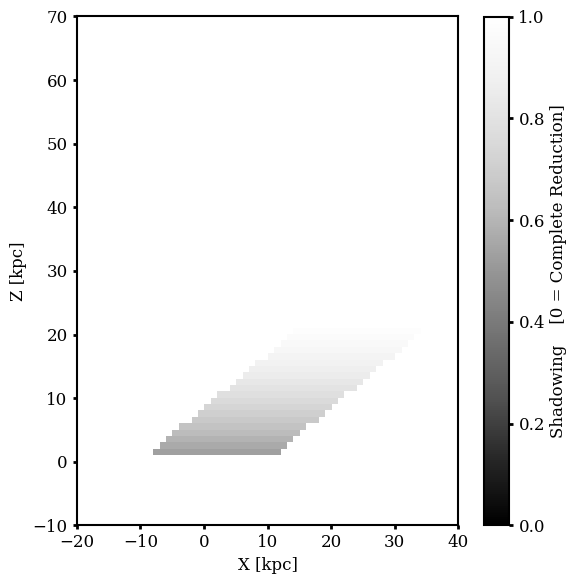

In [104]:
def plot_shadow_xz(shadow, ax=None, **kwargs):
    xrange = kwargs.get('xrange', (-20, 40))
    zrange = kwargs.get('zrange', (-10, 70))

    zs, xs = np.mgrid[zrange[0]:zrange[1], xrange[0]:xrange[1]]
    ys = np.zeros_like(xs)

    evaluation = shadow.evaluate(np.array([xs,ys,zs]).T, 0)
    
    plt.figure(figsize=kwargs.get('figsize', (6, 6)))
    plt.imshow(evaluation, origin="lower", cmap=kwargs.get("cmap", "Greys_r"), vmin=0, vmax=1, 
               extent=[xrange[0], xrange[1], zrange[0], zrange[1]])
    
    plt.xlabel("X [kpc]")
    plt.ylabel("Z [kpc]")
    plt.colorbar(label="Shadowing    [0 = Complete Reduction]")

    plt.tight_layout()
    
    outname = kwargs.get('outname', None)
    if outname is not None:
        plt.savefig(outname)
    else:
        plt.show()

plot_shadow_xz(shadow)